## Bernoulli VCM Results 

This notebook goes over the code needed to reproduce the results from the MSE and time figures for the Bernoulli base distribution with Logit Link and covariance matrix $\Gamma$ structured under variance component model framework as follows:

$$
\Gamma = 0.01 * \mathbf{1_{n} 1_{n}^\top}
$$

In this example simulate three fixed effects under GLMM with $\beta \sim$ randn(Uniform(-0.2, 0.2), p) where p = 3 fixed effects.


max_iter = 100, tol = 10^-8, limited_memory_max_history = 20, accept_after_max_steps = 1,

We run each scenario 100 times and compare the fit with that of GLMM's random intercept model from MixedModels.jl. 

In [1]:
versioninfo()

Julia Version 1.6.2
Commit 1b93d53fc4 (2021-07-14 15:36 UTC)
Platform Info:
  OS: macOS (x86_64-apple-darwin18.7.0)
  CPU: Intel(R) Core(TM) i9-9880H CPU @ 2.30GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-11.0.1 (ORCJIT, skylake)


In [2]:
using GLMCopula, DelimitedFiles, LinearAlgebra, Random, GLM
using Random, Roots, SpecialFunctions, DataFrames

In [3]:
p = 3    # number of fixed effects, including intercept
m = 1    # number of variance components
# true parameter values
Random.seed!(12345)
βtrue = rand(Uniform(-0.2, 0.2), p)
θtrue = [0.01]

# generate data
intervals = zeros(p + m, 2) #hold intervals
curcoverage = zeros(p + m) #hold current coverage resutls
trueparams = [βtrue; θtrue] #hold true parameters

#simulation parameters
samplesizes = [100; 1000; 10000]
ns = [2; 5; 10; 15; 20; 25]
nsims = 100;

In [4]:
@info "reading in the files with results"
βMseresult = vec(readdlm("mse_beta_multivariate_logistic_vcm$(nsims)reps_sim.csv", ','))
θMseresult = vec(readdlm("mse_Sigma_multivariate_logistic_vcm$(nsims)reps_sim.csv", ','))
fittimes_QC = vec(readdlm("fittimes_multivariate_logistic_vcm$(nsims)reps_sim.csv", ','))

┌ Info: reading in the files with results
└ @ Main In[4]:1


1800-element Vector{Float64}:
 0.019548254
 0.034241739
 0.042527322
 0.022210301
 0.023835685
 0.015449883
 0.018244704
 0.0425544
 0.027826678
 0.019218563
 0.01824479
 0.022443552
 0.015879391
 ⋮
 1.551814875
 1.09897217
 1.119580084
 1.162767399
 0.863168908
 1.231810276
 1.049585563
 1.434255399
 1.004477598
 1.106379196
 1.165408344
 1.112344121

In [5]:
fittimes_GLMM = vec(readdlm("fittimes_GLMM_multivariate_logistic_vcm$(nsims)reps_sim.csv", ','))

1800-element Vector{Float64}:
  0.271686061
  0.023975723
  0.011255335
  0.022203052
  0.011541597
  0.010938938
  0.011138593
  0.018296769
  0.014899484
  0.018940585
  0.019059808
  0.014434261
  0.012810342
  ⋮
 27.971229521
 27.82862459
 22.285341325
 18.608611511
 27.922289386
 25.397770155
 34.196022796
 26.155499166
 19.98285007
 20.195258565
 36.849316929
 28.047229793

In [8]:
#simulation parameters
@info "making results table Quasi-Copula"
sample_sizes = repeat(string.(samplesizes), inner = nsims * length(ns))
obs_sizes = repeat(string.(ns), inner = nsims, outer = length(samplesizes))

msedf = DataFrame(samplesize = sample_sizes, obssize = obs_sizes, fittimes = fittimes_QC)
msedf = filter(x -> !isnan(x.fittimes), msedf)

timedf1 = combine(groupby(msedf, [:samplesize, :obssize]), :fittimes => mean => :fittime,
    :fittimes => x -> (std(x)/sqrt(length(x))))
rename!(timedf1, Dict(:fittimes_function => "se"))
timedf1[!, :nobs] = Meta.parse.(timedf1[!, :samplesize]) .* Meta.parse.(timedf1[!, :obssize])
timedf1[!, :fitmin] = timedf1[!, :fittime] - timedf1[!, :se]
timedf1[!, :fitmax] = timedf1[!, :fittime] + 2 * timedf1[!, :se]
timedf1[!, :perobsratio] = timedf1[!, :fittime] ./ timedf1[!, :nobs]
timedf1

┌ Info: making results table Quasi-Copula
└ @ Main In[8]:2


,samplesize,obssize,fittime,se,nobs,fitmin,fitmax,perobsratio
,String,String,Float64,Float64,Int64,Float64,Float64,Float64
1,100,2,0.0353919,0.00374771,200,0.0316442,0.0428874,0.00017696
2,100,5,0.0269721,0.000824694,500,0.0261474,0.0286215,5.39442e-5
3,100,10,0.0310748,0.000919497,1000,0.0301553,0.0329138,3.10748e-5
4,100,15,0.0377598,0.00115131,1500,0.0366085,0.0400624,2.51732e-5
5,100,20,0.0414011,0.0015032,2000,0.0398979,0.0444075,2.07005e-5
6,100,25,0.0436033,0.0015276,2500,0.0420757,0.0466585,1.74413e-5
7,1000,2,0.044243,0.00374642,2000,0.0404966,0.0517358,2.21215e-5
8,1000,5,0.050192,0.00248103,5000,0.047711,0.0551541,1.00384e-5
9,1000,10,0.0554822,0.00152729,10000,0.0539549,0.0585368,5.54822e-6


In [9]:
#simulation parameters
@info "making results table GLMM"
sample_sizes = repeat(string.(samplesizes), inner = nsims * length(ns))
obs_sizes = repeat(string.(ns), inner = nsims, outer = length(samplesizes))

msedf = DataFrame(samplesize = sample_sizes, obssize = obs_sizes, fittimes = fittimes_GLMM)
msedf = filter(x -> !isnan(x.fittimes), msedf)

timedf2 = combine(groupby(msedf, [:samplesize, :obssize]), :fittimes => mean => :fittime,
    :fittimes => x -> (std(x)/sqrt(length(x))))
rename!(timedf2, Dict(:fittimes_function => "se"))
timedf2[!, :nobs] = Meta.parse.(timedf2[!, :samplesize]) .* Meta.parse.(timedf2[!, :obssize])
timedf2[!, :fitmin] = timedf2[!, :fittime] - timedf2[!, :se]
timedf2[!, :fitmax] = timedf2[!, :fittime] + timedf2[!, :se]
timedf2[!, :perobsratio] = timedf2[!, :fittime] ./ timedf2[!, :nobs]
timedf2

┌ Info: making results table GLMM
└ @ Main In[9]:2


,samplesize,obssize,fittime,se,nobs,fitmin,fitmax,perobsratio
,String,String,Float64,Float64,Int64,Float64,Float64,Float64
1,100,2,0.0267439,0.00365975,200,0.0230842,0.0304037,0.00013372
2,100,5,0.0381049,0.00136414,500,0.0367408,0.0394691,7.62099e-5
3,100,10,0.0788519,0.00309764,1000,0.0757542,0.0819495,7.88519e-5
4,100,15,0.118109,0.00423748,1500,0.113871,0.122346,7.87392e-5
5,100,20,0.165481,0.00793614,2000,0.157545,0.173417,8.27403e-5
6,100,25,0.199279,0.00739396,2500,0.191885,0.206673,7.97115e-5
7,1000,2,0.170908,0.00409011,2000,0.166818,0.174998,8.54539e-5
8,1000,5,0.455259,0.0108727,5000,0.444386,0.466132,9.10518e-5
9,1000,10,0.914746,0.0237696,10000,0.890977,0.938516,9.14746e-5


┌ Warning: RCall.jl: Warning: package ‘ggplot2’ was built under R version 4.0.2
└ @ RCall /Users/sarahji/.julia/packages/RCall/6kphM/src/io.jl:172
┌ Warning: RCall.jl: Warning: package ‘cowplot’ was built under R version 4.0.2
└ @ RCall /Users/sarahji/.julia/packages/RCall/6kphM/src/io.jl:172


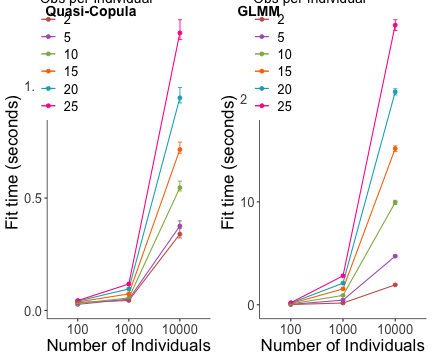

RObject{VecSxp}


In [10]:
########### plot the runtimes
using RCall
@rput timedf1
@rput timedf2
R"""
library(ggplot2)
library(cowplot)
timedf1$obssize = factor(timedf1$obssize, levels = c('2', '5', '10', '15', '20', '25'))
timedf1$samplesize = factor(timedf1$samplesize, levels = c('100', '1000', '10000'))

fittime_1 = ggplot(timedf1, aes(x = samplesize, y = fittime, group = obssize, color = obssize)) + 
  geom_line() +
  geom_point()+
  geom_errorbar(aes(ymin=fitmin, ymax=fitmax), width=0.5, alpha = 0.8, position=position_dodge(0.005)) + 
  theme(legend.position=c(0.3,0.85), legend.key = element_blank(), axis.text.x = element_text(angle=0, size=13),
        axis.text.y = element_text(angle=0, size=13), axis.title.x = element_text(size = 17), 
        axis.title.y = element_text(size = 17), legend.title = element_text(size = 14),
        #axis.ticks = element_blank(),
        panel.grid.major = element_blank(), legend.text=element_text(size=13),
        panel.border = element_blank(), panel.grid.minor = element_blank(), panel.background = element_blank(), 
        axis.line = element_line(color = 'black',size=0.3), plot.title = element_text(hjust = 0.5)) + 
   scale_color_manual(values = c("#c85f55",
"#a964bf",
"#8db352",
"#fa7300",
"#05aec0",
"#ff1493")) +
  labs(x = "Number of Individuals", y = "Fit time (seconds)", color = "Obs per Individual")

timedf2$obssize = factor(timedf2$obssize, levels = c('2', '5', '10', '15', '20', '25'))
timedf2$samplesize = factor(timedf2$samplesize, levels = c('100', '1000', '10000'))

fittime_2 = ggplot(timedf2, aes(x = samplesize, y = fittime, group = obssize, color = obssize)) + 
  geom_line() +
  geom_point()+
  geom_errorbar(aes(ymin=fitmin, ymax=fitmax), width=0.5, alpha = 0.8, position=position_dodge(0.005)) + 
  theme(legend.position=c(0.3,0.85), legend.key = element_blank(), axis.text.x = element_text(angle=0, size=13),
        axis.text.y = element_text(angle=0, size=13), axis.title.x = element_text(size = 17), 
        axis.title.y = element_text(size = 17), legend.title = element_text(size = 14),
        #axis.ticks = element_blank(),
        panel.grid.major = element_blank(), legend.text=element_text(size=13),
        panel.border = element_blank(), panel.grid.minor = element_blank(), panel.background = element_blank(), 
        axis.line = element_line(color = 'black',size=0.3), plot.title = element_text(hjust = 0.5)) + 
   scale_color_manual(values = c("#c85f55",
"#a964bf",
"#8db352",
"#fa7300",
"#05aec0",
"#ff1493")) +
  labs(x = "Number of Individuals", y = "Fit time (seconds)", color = "Obs per Individual")

fittime_nsamples = plot_grid(fittime_1, fittime_2, labels = c("Quasi-Copula", "GLMM"))
"""

In [11]:
R"""
ggsave('sim_glmm_fittime_nsamples_logistic_vs_glmm.png', fittime_nsamples, width = 15, height = 17, units = 'in', dpi = 450)
"""

RObject{StrSxp}
[1] "sim_glmm_fittime_nsamples_logistic_vs_glmm.png"


In [12]:
######  supplementary table s1
using Random, DataFrames, DelimitedFiles, Statistics
import StatsBase: sem

βθcoverage = readdlm("beta_sigma_coverage_multivariate_logistic_vcm$(nsims)reps_sim.csv", ',')

m  = 1

covdf = DataFrame(Matrix(transpose(βθcoverage)), :auto)
rename!(covdf, Symbol.([["β$i" for i in 1:p]; ["θ$i" for i in 1:m]]))
covdf[!, :samplesize] = sample_sizes
covdf[!, :obssize] = obs_sizes
first(covdf, 10)

row_stats = [[(mean(col), sem(col)) for col = eachcol(d[!, 1:end-2])] for d = groupby(covdf, [:samplesize; :obssize])]
df = DataFrame(row_stats, :auto)
ss_obs = unique("N: " .* sample_sizes .* "  ni: " .* obs_sizes)
rename!(df, Symbol.(ss_obs))
covdfdisplay = DataFrame([[names(df)]; collect.(eachrow(df))], 
    [:people_obs; Symbol.([["β$i" for i in 1:p]; ["θ$i" for i in 1:m]])])
# deletecols!(covdfdisplay, p + 2)
covdfdisplay


,people_obs,β1,β2,β3,θ1
,String,Tuple…,Tuple…,Tuple…,Tuple…
1,N: 100 ni: 2,"(0.77, 0.0422953)","(0.81, 0.0394277)","(0.79, 0.040936)","(0.95, 0.0219043)"
2,N: 100 ni: 5,"(0.84, 0.0368453)","(0.84, 0.0368453)","(0.86, 0.0348735)","(0.98, 0.0140705)"
3,N: 100 ni: 10,"(0.86, 0.0348735)","(0.86, 0.0348735)","(0.86, 0.0348735)","(0.92, 0.027266)"
4,N: 100 ni: 15,"(0.83, 0.0377525)","(0.77, 0.0422953)","(0.8, 0.0402015)","(0.91, 0.0287623)"
5,N: 100 ni: 20,"(0.83, 0.0377525)","(0.77, 0.0422953)","(0.71, 0.0456048)","(0.74, 0.0440844)"
6,N: 100 ni: 25,"(0.88, 0.0326599)","(0.87, 0.0337998)","(0.81, 0.0394277)","(0.65, 0.0479372)"
7,N: 1000 ni: 2,"(0.82, 0.0386123)","(0.79, 0.040936)","(0.81, 0.0394277)","(0.94, 0.0238683)"
8,N: 1000 ni: 5,"(0.79, 0.040936)","(0.82, 0.0386123)","(0.8, 0.0402015)","(0.85, 0.035887)"
9,N: 1000 ni: 10,"(0.82, 0.0386123)","(0.84, 0.0368453)","(0.85, 0.035887)","(0.52, 0.0502117)"


In [13]:
#### 
#import data and reorganize to create figure
using Random, DataFrames, DelimitedFiles, Statistics, RCall, Printf
import StatsBase: sem

βMseresult = vec(readdlm("mse_beta_multivariate_logistic_vcm$(nsims)reps_sim.csv", ','))
θMseresult = vec(readdlm("mse_Sigma_multivariate_logistic_vcm$(nsims)reps_sim.csv", ','))

βMseresult_GLMM = vec(readdlm("mse_beta_GLMM_multivariate_logistic_vcm$(nsims)reps_sim.csv", ','))
θMseresult_GLMM = vec(readdlm("mse_Sigma_GLMM_multivariate_logistic_vcm$(nsims)reps_sim.csv", ','))


p = 3; m = 1
sample_sizes = repeat(string.(samplesizes), inner = nsims * length(ns))
obs_sizes = repeat(string.(ns), inner = nsims, outer = length(samplesizes))
msedf1 = DataFrame(βmse = βMseresult, thetamse = θMseresult, 
    samplesize = sample_sizes, obssize = obs_sizes)

msedf2 = DataFrame(βmse = βMseresult_GLMM, thetamse = θMseresult_GLMM, 
    samplesize = sample_sizes, obssize = obs_sizes)

#rename to make parsing easier for R.

msedf1 = deepcopy(msedf1)
rename!(msedf1, ["betamse"
    "thetamse"
    "samplesize"
 "obssize"]);

msedf2 = deepcopy(msedf2)
rename!(msedf2, ["betamse"
    "thetamse"
    "samplesize"
 "obssize"]);

mses = [msedf1[!, :betamse]; msedf1[!, :thetamse]; msedf2[!, :betamse]; msedf2[!, :thetamse]]
    # msedfnormR[!, :betamse]; msedfnormR[!, :taumse]; msedfnormR[!, :Sigmamse]]
obssize = [collect([repeat(msedf1[!, :obssize], 2)]...) ; collect([repeat(msedf2[!, :obssize], 2)]...)]
#40
samplesize = [collect([repeat(msedf1[!, :samplesize], 2)]...) ; collect([repeat(msedf2[!, :samplesize], 2)]...)]

parameters = [collect([repeat(string.([:beta, :theta]), inner = nsims * length(ns) * length(samplesizes))]...) ; collect([repeat(string.([:beta, :theta]), inner = nsims * length(ns) * length(samplesizes))]...)]
robust = [collect([repeat(["Bernoulli QC"], 2 * nsims * length(ns) * length(samplesizes))]...); collect([repeat(["Bernoulli GLMM"],  2 * nsims * length(ns) * length(samplesizes))]...)]

msedfR = DataFrame(mse = mses, obssize = obssize, samplesize = samplesize,
    parameters = parameters, robust = robust)

#5 of the 30,000 simulations did not converge, filter out
msedfR = filter(x -> !isnan(x.mse), msedfR)
# additionally, there are 5 where an error was not caught so it did not try a differnt solver
msedfR = filter(x -> x.mse < 40000, msedfR)

,mse,obssize,samplesize,parameters,robust
,Float64,String,String,String,String
1,0.0048039,2,100,beta,Bernoulli QC
2,0.0115777,2,100,beta,Bernoulli QC
3,0.0164307,2,100,beta,Bernoulli QC
4,0.00910742,2,100,beta,Bernoulli QC
5,0.0125818,2,100,beta,Bernoulli QC
6,0.0445076,2,100,beta,Bernoulli QC
7,0.0030897,2,100,beta,Bernoulli QC
8,0.0496311,2,100,beta,Bernoulli QC
9,0.0152344,2,100,beta,Bernoulli QC


┌ Warning: RCall.jl: Warning: package ‘scales’ was built under R version 4.0.2
└ @ RCall /Users/sarahji/.julia/packages/RCall/6kphM/src/io.jl:172
┌ Warning: RCall.jl: Warning: package ‘data.table’ was built under R version 4.0.2
└ @ RCall /Users/sarahji/.julia/packages/RCall/6kphM/src/io.jl:172


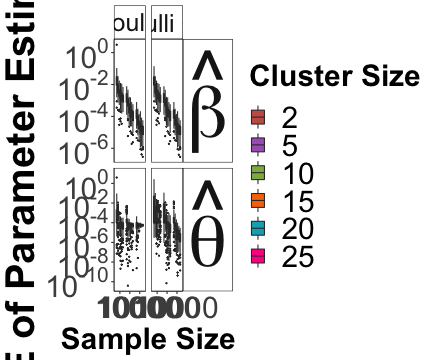

RObject{VecSxp}


In [14]:
### working on figure next
@rput msedfR

R"""
library(scales)
library(ggplot2)
library(data.table)

msedfR = data.table(msedfR)

msedfR[parameters == "beta",y_min := 10^-6]
msedfR[parameters == "beta",y_max := 10^0]
msedfR[parameters == "theta",y_min := 10^-5]
msedfR[parameters == "theta",y_max := 10^1]

#msedfR[parameters == "beta",y_min := 10^-8]
#msedfR[parameters == "beta",y_max := 10^-2]
#msedfR[parameters == "tau",y_min := 10^-8]
#msedfR[parameters == "tau",y_max := 10^-2]
#msedfR[parameters == "Sigma",y_min := 10^-5]
#msedfR[parameters == "Sigma",y_max := 10^-2]


msedfR$obssize = factor(msedfR$obssize, levels = c('2', '5', '10', '15', '20', '25'))
msedfR$samplesize = factor(msedfR$samplesize, levels = c('100', '1000', '10000'))
msedfR$parameters = factor(msedfR$parameters, levels = c('beta', 'theta'), labels = c(beta = expression(hat(bold(beta))), theta = expression(hat(bold(theta))[])))
msedfR$robust <- factor(msedfR$robust, levels = c('Bernoulli QC', 'Bernoulli GLMM'),
    labels = c(expression(paste("Bernoulli QC")), expression(paste("Bernoulli GLMM"))))


#mseplot <- ggplot(msedfR[msedfR$mse < 10^0, ], aes(x=samplesize, y=mse, fill=obssize)) + 
#mseplot <- ggplot(msedfR[msedfR$mse < 10^0, ], aes(x=samplesize, y=mse, fill=obssize)) + 
mseplot = ggplot(msedfR[msedfR$mse < 10^3, ], aes(x=samplesize, y=mse, fill=obssize)) + 
  #geom_boxplot(outlier.size = 0.0, outlier.alpha = 0) +
  geom_boxplot(outlier.size = 0.25) +
#    geom_violin() +
    facet_grid(parameters ~ robust, labeller = label_parsed, scales = "free_y") +
  theme(legend.position="right", legend.key = element_blank(), axis.text.x = element_text(angle=0, size=30),
        axis.text.y = element_text(angle=0, size=30), axis.title.x = element_text(size = 30, face="bold"), 
        axis.title.y = element_text(size = 40, face="bold"), legend.title = element_text(size = 30, face="bold"),
        panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
        legend.text=element_text(size=30), panel.background = element_rect(fill = NA, color = "black"),
        #panel.background = element_blank(), #panel.border = element_blank(),
        axis.line = element_line(color = 'black',size=0.3), plot.title = element_text(hjust = 0.5),
        strip.background = element_rect(colour="black", fill="white"), strip.text.y = element_text(angle = 0, size=75, face="bold"),
        strip.text.x = element_text(size=25)) + 
  scale_fill_manual(values = c("#c85f55",
"#a964bf",
"#8db352",
"#fa7300",
"#05aec0",
"#ff1493")) +
#scale_y_log10(breaks = scales::trans_breaks("log10", function(x) 10^x)) +
#scale_y_log10(breaks = 10^(-8:8), limit=c(10^-8, 10^2)) + 
scale_y_log10(breaks = 10^seq(-10, 10, 2), labels=trans_format("log10", math_format(10^.x))) + #, limit=c(10^-8, 10^2)) +
  labs(x = "Sample Size", y = "MSE of Parameter Estimates", fill = "Cluster Size") +
geom_blank(aes(y = y_max)) + 
geom_blank(aes(y = y_min)) 
"""

In [15]:
R"""
    ggsave('sim_glmm_updated_msefacetplot_bernoulli_0.01.png', mseplot, width = 20, height = 15, units = 'in', dpi = 450)
"""

RObject{StrSxp}
[1] "sim_glmm_updated_msefacetplot_bernoulli_0.01.png"
